In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from os import walk
from os.path import join

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup


In [206]:
#const
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word_by_id.csv'


In [153]:
st = open(EXAMPLE_FILE, encoding='latin-1')
is_body = False
lines = []
for line in st: 
    if is_body:
        lines.append(line)
    elif line=='\n':
        is_body=True         
st.close()
#print(''.join(lines))
#print(type(message))
#print(message)

In [154]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            fpath = join(root,file_name)
            stream = open(fpath, encoding='latin-1')
            is_body = False
            lines = []
            for line in stream: 
                if is_body:
                    lines.append(line)
                elif line=='\n':
                    is_body=True 
            stream.close()
            email_body = '\n'.join(lines)
            yield file_name, email_body
          


In [155]:
def df_from_dir(path, classification):
    rows = []
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body, 'CATEGORY':classification})
        row_names.append(file_name)
    
    return pd.DataFrame(rows, row_names)

In [156]:
spam_emails = df_from_dir(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_dir(SPAM_2_PATH, SPAM_CAT) )
spam_emails.head(1)

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1


In [157]:
spam_emails.shape

(1898, 2)

In [158]:
ham_emails = df_from_dir(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_dir(EASY_NONSPAM_2_PATH, HAM_CAT) )
ham_emails.head(1)

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0


In [159]:
ham_emails.shape

(3901, 2)

In [160]:
data = pd.concat([spam_emails, ham_emails])
print(data.shape)
 

(5799, 2)


In [161]:
data[data['MESSAGE'].str.len() == 0] 

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


In [162]:
data.drop(['cmds'], inplace=True)

In [163]:
print(data.shape)

(5796, 2)


In [164]:
docids = range(len(data)) 
docids

range(0, 5796)

In [165]:
data['FILE_NAME'] = data.index
data.head(1)

,MESSAGE,CATEGORY,FILE_NAME
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0


In [166]:
data['DOC_ID'] = docids
data.set_index('DOC_ID', inplace=True)
data.head(1)

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0


#save to json

In [167]:
data.to_json(DATA_JSON_FILE)

In [168]:
# spam / ham visualized 

In [169]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [170]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

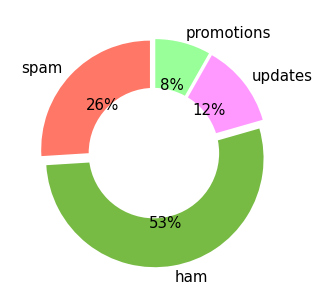

In [171]:
category_names = ['spam', 'ham', 'updates', 'promotions']
sizes = [amount_of_spam, amount_of_ham, 900, 600]
colors = ['#ff7766','#77bb44', '#ff99ff' , '#99ff99']
offset = [0.05,0.05,0.05,0.05]
plt.figure(figsize=(2,2), dpi=180 )
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
        autopct='%1.0f%%', colors=colors, explode=offset)

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)
plt.show()

In [172]:
# natural language processing

In [173]:
msg = 'All work and not play makes jack a dull boy. To be or not to be. \
nobody expects the spanish inquisition'

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [174]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [175]:
words = word_tokenize(msg.lower())

In [176]:
#remove stopwords
stop_words = set(stopwords.words('english')) 
#print(stop_words)

In [177]:
filtered = []  
stemmer = PorterStemmer()
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered.append(stemmed_word)
 
print(filtered)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


In [178]:
soup = BeautifulSoup(data.at[2,'MESSAGE'], 'html.parser')
#  print(soup.prettify())
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [179]:
def clean_message_no_html(message
                  , stemmer=PorterStemmer()
                  , stop_words=set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text=soup.get_text()
    words = word_tokenize(cleaned_text.lower())
    filtered_words = []
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word)) 
    return filtered_words

In [180]:
%%time
#first_emails = data.MESSAGE[0:3]
nested_list = data.MESSAGE.apply(clean_message_no_html)
len(nested_list)     

C:\Users\Tim\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 30 s


5796

In [181]:
doc_ids_spam = set( data[data.CATEGORY==SPAM_CAT].index.values )
doc_ids_ham =  set( data[data.CATEGORY==HAM_CAT].index.values  ) 
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]

In [149]:
ham_words = [word for words in nested_list_ham for word in words ]
normal_words = pd.Series(ham_words).value_counts()

spam_words = [word for words in nested_list_spam for word in words ]
spam_words = pd.Series(spam_words).value_counts()

spam_words[:5]

http      3097
email     3090
free      2585
click     2058
receiv    1989
dtype: int64

In [183]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\Tim\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [184]:
unique_words = pd.Series(flat_stemmed_list).value_counts() 

27334


In [202]:
frequent_words = unique_words[0:VOCAB_SIZE]

In [212]:
vocab = pd.DataFrame(flat_stemmed_list, index=range(len(flat_stemmed_list)))
vocab.index.name = 'WORD_ID'   
vocab.columns = ['VOCAB_WORD']
#vocab['WORD_ID'] = )
#vocab.set_index('WORD_ID', inplace=True)
vocab.head(15)

,VOCAB_WORD
WORD_ID,
0,save
1,life
2,insur
3,spend
4,life
5,quot
6,save
7,g
8,famili


In [218]:
vocab.to_csv(WORD_ID_FILE , index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

In [225]:
'save' in set(vocab['VOCAB_WORD']) 

True

In [226]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [241]:
data.iloc[0]['MESSAGE']
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list  ] 

print(max(clean_email_lengths))
print('location of largest message' , np.argmax(clean_email_lengths))

7671
location of largest message 5775


In [246]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist()) 

(5796, 7671)

In [ ]:
word_columns_df.shape